In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras import layers, regularizers
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from keras import activations
from keras import callbacks



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset_path = "/content/drive/My Drive/fruits-360/Training"
test_dataset_path = "/content/drive/My Drive/fruits-360/Test"

### **Removing extra class from the train directory as there was a class imbalance between train and test**

In [ ]:
import os
import shutil

# Define the training dataset path
train_dataset_path = "/content/drive/My Drive/fruits-360/Training"

# Class to be removed
class_to_remove = "Caju seed 1"

# Function to remove a class directory
def remove_class(dataset_path, class_name):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.exists(class_path):
        shutil.rmtree(class_path)  # Remove the directory and its contents
        print(f"Removed class '{class_name}' from {dataset_path}")
    else:
        print(f"Class '{class_name}' not found in {dataset_path}")

# Remove the class from the training dataset
remove_class(train_dataset_path, class_to_remove)


Class 'Caju seed 1' not found in /content/drive/My Drive/fruits-360/Training


## **Load Datasets**

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dataset_path,
    image_size=(128, 128),
    batch_size=32
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dataset_path,
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_dataset_path,
    image_size=(128, 128),
    batch_size=32)

class_names = train_dataset.class_names


Found 82800 files belonging to 164 classes.
Found 82800 files belonging to 164 classes.
Using 16560 files for validation.
Found 27571 files belonging to 164 classes.


## **Data Exploration**

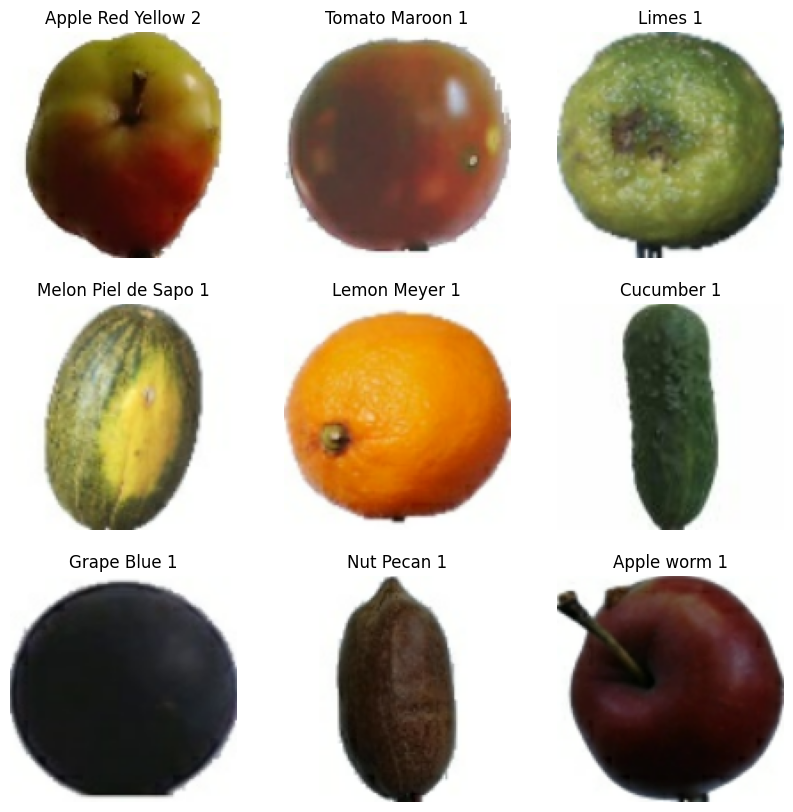

In [ ]:
# Data Exploration
# Display sample images
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

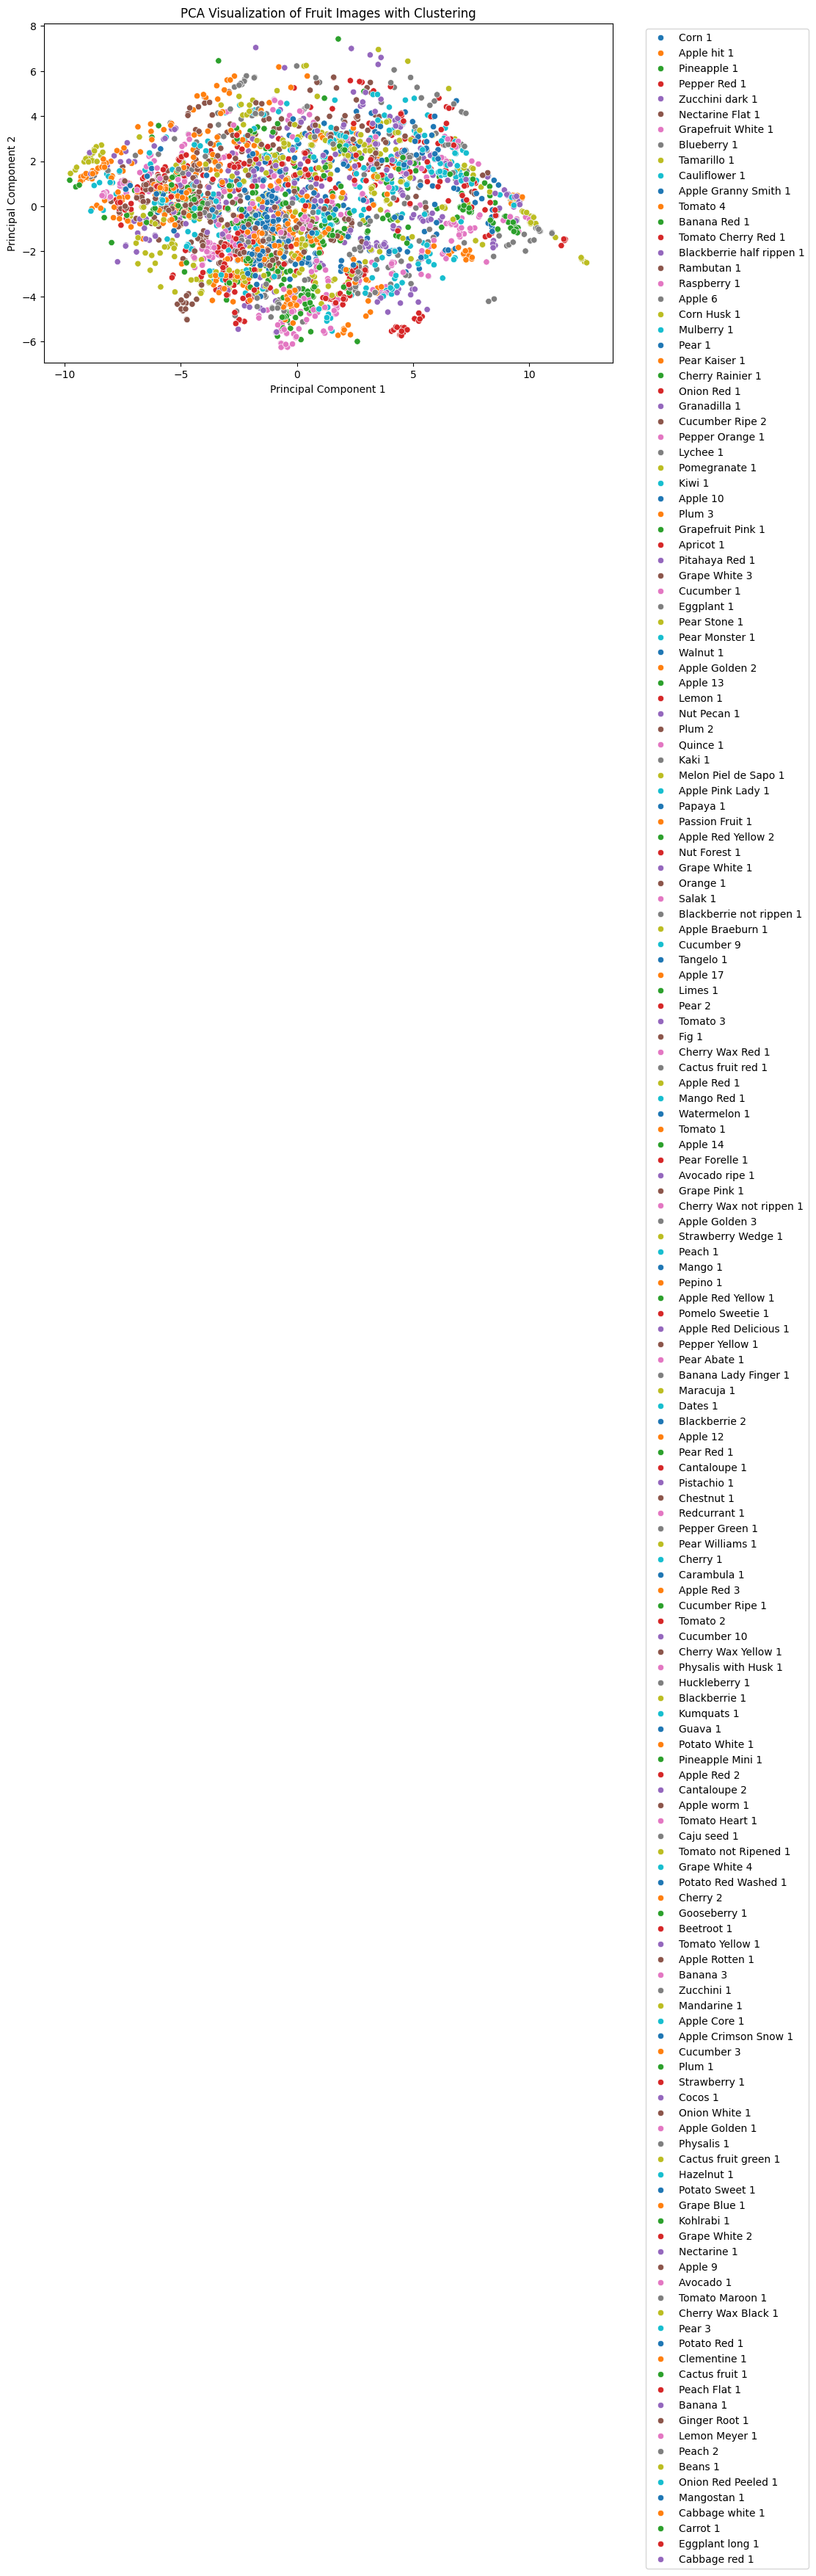

In [ ]:
# Extract image features for clustering
feature_extractor = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten()
])

image_features = []
labels_list = []
for images, labels in train_dataset.take(100):
    features = feature_extractor.predict(images)
    image_features.append(features)
    labels_list.extend(labels.numpy())

image_features = np.vstack(image_features)
labels_list = np.array(labels_list)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(image_features)

# Perform clustering
kmeans = KMeans(n_clusters=len(class_names), random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_features)

# Visualize clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=[class_names[i] for i in labels_list], palette='tab10')
plt.title("PCA Visualization of Fruit Images with Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##**Baseline model**

In [ ]:

# Define Baseline CNN Model with 7 layers
def create_baseline_model():
    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(128, 128, 3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Baseline Model
baseline_model = create_baseline_model()
baseline_history = baseline_model.fit(train_dataset, epochs=5, validation_data=val_dataset)
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(test_dataset)
print(f"Baseline Model Test Accuracy: {baseline_test_acc:.4f}")

# Generate Classification Report
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
baseline_y_pred = np.argmax(baseline_model.predict(test_dataset), axis=1)
print("Baseline Model Classification Report:")
print(classification_report(y_true, baseline_y_pred, target_names=class_names))



Epoch 1/5
 117/2077 ━━━━━━━━━━━━━━━━━━━━ 1:15:03 2s/step - accuracy: 0.1876 - loss: 4.0971

KeyboardInterrupt: 

### **Analysis** : The model shows severe overfitting, achieving nearly 100% accuracy on training and validation but only 22.53% on test data, indicating poor generalization. The high test loss (39.5140) suggests the model is struggling with unseen data, likely due to excessive complexity and lack of regularization. To improve, adding Dropout layers, Data Augmentation, or reducing model complexity is recommended.

## Structural Changes in **Second CNN Model**
**Reduced Convolutional Filters:**

Baseline: Used 32 & 64 filters in Conv layers.

Second Model: Reduced to 16 & 32 to simplify the model.

**Increased Pooling Size:**

Baseline: Used 2×2 pooling.

Second Model: Used 3×3 to reduce feature map dimensions more aggressively.

**Added Dropout (0.3):**

Helps prevent overfitting by randomly disabling neurons during training.

In [ ]:
# Define Second CNN Model with Reduced Complexity
def create_second_cnn_model():
    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(128, 128, 3)),
        layers.Conv2D(16, (3,3), activation='relu'),  # Reduced filters from 32 to 16
        layers.MaxPooling2D(3,3),  # Increased pooling size to reduce feature maps
        layers.Conv2D(32, (3,3), activation='relu'),  # Reduced filters from 64 to 32
        layers.MaxPooling2D(3,3),  # Increased pooling size
        layers.Flatten(),
        layers.Dropout(0.3),  # Added dropout to prevent overfitting
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Second CNN Model
second_cnn_model = create_second_cnn_model()
second_cnn_history = second_cnn_model.fit(train_dataset, epochs=5, validation_data=val_dataset)
second_cnn_test_loss, second_cnn_test_acc = second_cnn_model.evaluate(test_dataset)
print(f"Second CNN Model Test Accuracy: {second_cnn_test_acc:.4f}")

# Generate Classification Report
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred = np.argmax(second_cnn_model.predict(test_dataset), axis=1)
print("Second CNN Model Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Epoch 1/5
2588/2588 ━━━━━━━━━━━━━━━━━━━━ 2856s 1s/step - accuracy: 0.8005 - loss: 0.8767 - val_accuracy: 0.9955 - val_loss: 0.0151
Epoch 2/5
2588/2588 ━━━━━━━━━━━━━━━━━━━━ 1185s 439ms/step - accuracy: 0.9909 - loss: 0.0332 - val_accuracy: 0.9987 - val_loss: 0.0042
Epoch 3/5
2588/2588 ━━━━━━━━━━━━━━━━━━━━ 1146s 433ms/step - accuracy: 0.9954 - loss: 0.0182 - val_accuracy: 0.9999 - val_loss: 8.6029e-04
Epoch 4/5
2588/2588 ━━━━━━━━━━━━━━━━━━━━ 1160s 432ms/step - accuracy: 0.9979 - loss: 0.0080 - val_accuracy: 0.9999 - val_loss: 9.9191e-04
Epoch 5/5
2588/2588 ━━━━━━━━━━━━━━━━━━━━ 1067s 412ms/step - accuracy: 0.9974 - loss: 0.0105 - val_accuracy: 0.9982 - val_loss: 0.0050
862/862 ━━━━━━━━━━━━━━━━━━━━ 2861s 3s/step - accuracy: 0.9549 - loss: 0.2888
Second CNN Model Test Accuracy: 0.9545
862/862 ━━━━━━━━━━━━━━━━━━━━ 163s 189ms/step
Second CNN Model Classification Report:
                           precision    recall  f1-score   support

                 Apple 10       0.02      0.02      0.02

## **Analysis of second model** :

### Slight improvement in test accuracy (22.53% → 24.24%), but still very low compared to validation accuracy.

### Loss on test set remains extremely high (36.1150), indicating severe overfitting.

### Training and validation accuracies remain high, suggesting the model is memorizing the training data instead of generalizing.

## **Changes Made in third model :**

### Added two more convolution layers.

### Changed number of epochs to 7 because timing out on 10


In [ ]:
# Define Third CNN Model with Additional Convolutional Layers

def create_third_cnn_model():
    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(128, 128, 3)),
        layers.Conv2D(16, (3,3), activation='relu'),  # First convolution layer
        layers.Conv2D(32, (3,3), activation='relu'),  # Added convolution layer
        layers.MaxPooling2D(3,3),  # Increased pooling size to reduce feature maps
        layers.Conv2D(64, (3,3), activation='relu'),  # Second convolution layer
        layers.Conv2D(96, (3,3), activation='relu'),  # Added convolution layer
        layers.MaxPooling2D(3,3),  # Increased pooling size
        layers.Flatten(),
        layers.Dropout(0.3),  # Added dropout to prevent overfitting
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Third CNN Model
third_cnn_model = create_third_cnn_model()
third_cnn_history = third_cnn_model.fit(train_dataset, epochs=7, validation_data=val_dataset)
third_cnn_test_loss, third_cnn_test_acc = third_cnn_model.evaluate(test_dataset)
print(f"Third CNN Model Test Accuracy: {third_cnn_test_acc:.4f}")

# Generate Classification Report
y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
third_cnn_y_pred = np.argmax(third_cnn_model.predict(test_dataset), axis=1)
print("Third CNN Model Classification Report:")
print(classification_report(y_true, third_cnn_y_pred, target_names=class_names))


Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2596/2596 ━━━━━━━━━━━━━━━━━━━━ 9048s 3s/step - accuracy: 0.7966 - loss: 0.8869 - val_accuracy: 0.9949 - val_loss: 0.0227
Epoch 2/7
2596/2596 ━━━━━━━━━━━━━━━━━━━━ 3191s 1s/step - accuracy: 0.9905 - loss: 0.0335 - val_accuracy: 0.9986 - val_loss: 0.0086
Epoch 3/7
2596/2596 ━━━━━━━━━━━━━━━━━━━━ 3336s 1s/step - accuracy: 0.9949 - loss: 0.0174 - val_accuracy: 0.9984 - val_loss: 0.0122
Epoch 4/7
2596/2596 ━━━━━━━━━━━━━━━━━━━━ 3552s 1s/step - accuracy: 0.9943 - loss: 0.0202 - val_accuracy: 0.9995 - val_loss: 0.0013
Epoch 5/7
2596/2596 ━━━━━━━━━━━━━━━━━━━━ 3369s 1s/step - accuracy: 0.9968 - loss: 0.0112 - val_accuracy: 0.9983 - val_loss: 0.0068
Epoch 6/7
2596/2596 ━━━━━━━━━━━━━━━━━━━━ 3403s 1s/step - accuracy: 0.9973 - loss: 0.0103 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 7/7
2596/2596 ━━━━━━━━━━━━━━━━━━━━ 3536s 1s/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9992 - val_loss: 0.0023
862/862 ━━━━━━━━━━━━━━━━━━━━ 2993s 3s/step - accuracy: 0.2345 - loss: 49.4800
Third CNN Model

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Test Data split from Train - Second CNN model

In [ ]:
import tensorflow as tf

# First, create the training dataset (80% of total)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dataset_path,
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,  # 20% reserved for val + test
    subset="training",
    seed=123
)

# Create the remaining dataset (20% of total)
remaining_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dataset_path,
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Calculate the number of batches in remaining_dataset
num_batches = len(remaining_dataset)

# Split remaining dataset into validation (10%) and test (10%)
val_batches = num_batches // 2  # 50% of remaining data (10% of total)
test_batches = num_batches - val_batches  # Remaining 50% (10% of total)

val_dataset = remaining_dataset.take(val_batches)
test_dataset = remaining_dataset.skip(val_batches)

# Check dataset sizes
print(f"Train dataset size: {len(train_dataset)} batches")
print(f"Validation dataset size: {len(val_dataset)} batches")
print(f"Test dataset size: {len(test_dataset)} batches")

class_names = train_dataset.class_names


Found 83066 files belonging to 165 classes.
Using 66453 files for training.
Found 83066 files belonging to 165 classes.
Using 16613 files for validation.
Train dataset size: 2077 batches
Validation dataset size: 260 batches
Test dataset size: 260 batches


In [ ]:
# Define Second CNN Model with Reduced Complexity
def create_second_cnn_model():
    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(128, 128, 3)),
        layers.Conv2D(16, (3,3), activation='relu'),  # Reduced filters from 32 to 16
        layers.MaxPooling2D(3,3),  # Increased pooling size to reduce feature maps
        layers.Conv2D(32, (3,3), activation='relu'),  # Reduced filters from 64 to 32
        layers.MaxPooling2D(3,3),  # Increased pooling size
        layers.Flatten(),
        layers.Dropout(0.3),  # Added dropout to prevent overfitting
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Second CNN Model
second_cnn_model = create_second_cnn_model()
second_cnn_history = second_cnn_model.fit(train_dataset, epochs=5, validation_data=val_dataset)
second_cnn_test_loss, second_cnn_test_acc = second_cnn_model.evaluate(test_dataset)
print(f"Second CNN Model Test Accuracy: {second_cnn_test_acc:.4f}")

# Generate Classification Report
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(second_cnn_model.predict(test_dataset), axis=1)
print("Second CNN Model Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Epoch 1/5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 15216s 7s/step - accuracy: 0.7753 - loss: 1.0021 - val_accuracy: 0.9950 - val_loss: 0.0209
Epoch 2/5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 921s 421ms/step - accuracy: 0.9927 - loss: 0.0265 - val_accuracy: 0.9936 - val_loss: 0.0189
Epoch 3/5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 920s 420ms/step - accuracy: 0.9959 - loss: 0.0145 - val_accuracy: 0.9986 - val_loss: 0.0054
Epoch 4/5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 903s 410ms/step - accuracy: 0.9973 - loss: 0.0098 - val_accuracy: 0.9993 - val_loss: 0.0035
Epoch 5/5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 863s 411ms/step - accuracy: 0.9968 - loss: 0.0114 - val_accuracy: 0.9946 - val_loss: 0.0161
260/260 ━━━━━━━━━━━━━━━━━━━━ 2848s 11s/step - accuracy: 0.9960 - loss: 0.0167
Second CNN Model Test Accuracy: 0.9946
260/260 ━━━━━━━━━━━━━━━━━━━━ 89s 202ms/step
Second CNN Model Classification Report:
                           precision    recall  f1-score   support

                 Apple 10       0.03      0.03      0.03        73


## **Analysis**
The Second CNN Model demonstrates excellent overall performance, achieving a test accuracy of 99.46% with rapidly improving training metrics and minimal loss by epoch 5.  

### The test accuracy went up from 23.45% to 99.46%

### Might be class imbalance

## Using **ImageDataGenerator**

In [ ]:

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


class_names = list(train_dataset.class_indices.keys())


Found 66289 images belonging to 164 classes.
Found 16511 images belonging to 164 classes.
Found 27571 images belonging to 164 classes.


In [ ]:
# Define Second CNN Model with Reduced Complexity
def create_second_cnn_new():
    model = keras.Sequential([
        layers.Input(shape=(128, 128, 3)),  # Explicit input layer
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D(3, 3),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(3, 3),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train model
second_cnn_new = create_second_cnn_new()
history = second_cnn_new.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

# Evaluate on test set
test_loss, test_acc = second_cnn_new.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Generate predictions
test_dataset.reset()  # Reset generator to ensure order
y_pred = second_cnn_new.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)

# Get ALL true labels (not just the first batch)
y_true = test_dataset.classes  # Correct way to get all labels

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 912s 439ms/step - accuracy: 0.7731 - loss: 1.0402 - val_accuracy: 0.9228 - val_loss: 0.3883
Epoch 2/5
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 920s 444ms/step - accuracy: 0.9931 - loss: 0.0248 - val_accuracy: 0.9211 - val_loss: 0.3671
Epoch 3/5
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 894s 431ms/step - accuracy: 0.9955 - loss: 0.0178 - val_accuracy: 0.9324 - val_loss: 0.3800
Epoch 4/5
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 876s 423ms/step - accuracy: 0.9981 - loss: 0.0072 - val_accuracy: 0.9170 - val_loss: 0.4412
Epoch 5/5
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 910s 439ms/step - accuracy: 0.9985 - loss: 0.0064 - val_accuracy: 0.9321 - val_loss: 0.4710
862/862 ━━━━━━━━━━━━━━━━━━━━ 5655s 7s/step - accuracy: 0.9395 - loss: 0.4662

Test Accuracy: 0.9468
862/862 ━━━━━━━━━━━━━━━━━━━━ 192s 222ms/step

Classification Report:
                           precision    recall  f1-score   support

                 Apple 10       1.00      0.97      0.98       231
                 Apple 12      

## **Third CNN model** using **ImageDataGenerator** with **Filtered DataSet with half the data**

In [ ]:
import os
import shutil
import random

# === Your actual dataset paths ===
original_train_dir = "/content/drive/My Drive/fruits-360/Training"  # Original training data
original_test_dir = "/content/drive/My Drive/fruits-360/Test"      # Original test data

# === Output directory base ===
base_output_path = "/content/drive/My Drive/fruits-360-filtered"    # New filtered dataset
filtered_train_dir = os.path.join(base_output_path, 'train')
filtered_test_dir = os.path.join(base_output_path, 'test')

# === Number of classes to sample ===
num_classes = 82

# === Ensure fresh output directories ===
def reset_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)  # Remove existing directory
    os.makedirs(path)      # Create a new directory

reset_dir(filtered_train_dir)
reset_dir(filtered_test_dir)

# === Get all class folders from training set ===
all_classes = sorted([
    folder for folder in os.listdir(original_train_dir)
    if os.path.isdir(os.path.join(original_train_dir, folder))
])
selected_classes = random.sample(all_classes, num_classes)
print(f"🎯 Selected {len(selected_classes)} classes.")

# === Helper function to copy folders ===
def copy_selected_classes(class_list, src_dir, dest_dir):
    for cls in class_list:
        src_path = os.path.join(src_dir, cls)
        dest_path = os.path.join(dest_dir, cls)
        if os.path.exists(src_path):
            shutil.copytree(src_path, dest_path, dirs_exist_ok=True)

# === Copy selected classes ===
print("📦 Copying training data...")
copy_selected_classes(selected_classes, original_train_dir, filtered_train_dir)

print("📦 Copying test data...")
copy_selected_classes(selected_classes, original_test_dir, filtered_test_dir)

print(f"✅ Done! Filtered dataset created at: {base_output_path}")


🎯 Selected 82 classes.
📦 Copying training data...
📦 Copying test data...
✅ Done! Filtered dataset created at: /content/drive/My Drive/fruits-360-filtered


## **Checking both the filtered test ,filtered train datasets have same classes.**

In [ ]:
import os

# Define the paths to your filtered datasets
filtered_train_dir = "/content/drive/My Drive/fruits-360-filtered/train"
filtered_test_dir = "/content/drive/My Drive/fruits-360-filtered/test"

# List the classes in the train directory
train_classes = sorted(os.listdir(filtered_train_dir))
print(f"Training classes ({len(train_classes)}):", train_classes)

# List the classes in the test directory
test_classes = sorted(os.listdir(filtered_test_dir))
print(f"Test classes ({len(test_classes)}):", test_classes)

# Compare the class lists
if set(train_classes) == set(test_classes):
    print("✅ The classes match in both train and test datasets.")
else:
    print("❌ The classes do NOT match!")
    # Find classes that are in train but not in test
    missing_in_test = set(train_classes) - set(test_classes)
    print("Classes in train but not in test:", missing_in_test)

    # Find classes that are in test but not in train
    missing_in_train = set(test_classes) - set(train_classes)
    print("Classes in test but not in train:", missing_in_train)


Training classes (82): ['Apple 10', 'Apple 12', 'Apple 14', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Rotten 1', 'Apple worm 1', 'Banana 1', 'Banana 3', 'Banana Lady Finger 1', 'Beans 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit green 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Cherry 1', 'Cherry Rainier 1', 'Cherry Wax not rippen 1', 'Clementine 1', 'Corn 1', 'Cucumber 1', 'Cucumber 9', 'Cucumber Ripe 2', 'Eggplant 1', 'Eggplant long 1', 'Fig 1', 'Gooseberry 1', 'Grape White 1', 'Grape White 3', 'Grape White 4', 'Guava 1', 'Hazelnut 1', 'Kaki 1', 'Kiwi 1', 'Kohlrabi 1', 'Limes 1', 'Lychee 1', 'Mandarine 1', 'Melon Piel de Sapo 1', 'Mulberry 1', 'Nut Forest 1', 'Onion Red 1', 'Onion Red Peeled 1', 'Onion White 1', 'Passion Fruit 1', 'Peach

## **Loading the Datasets**

In [ ]:
from tensorflow import keras

# === Update these paths to point to your filtered dataset ===
filtered_train_path = "/content/drive/My Drive/fruits-360-filtered/train"
filtered_test_path = "/content/drive/My Drive/fruits-360-filtered/test"

# Data generators
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # For splitting into training and validation
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load training dataset
train_dataset = train_datagen.flow_from_directory(
    filtered_train_path,  # Pointing to the filtered training dataset
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Using the training subset
)

# Load validation dataset
val_dataset = train_datagen.flow_from_directory(
    filtered_train_path,  # Pointing to the same filtered training dataset
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Using the validation subset
)

# Load test dataset
test_dataset = test_datagen.flow_from_directory(
    filtered_test_path,  # Pointing to the filtered test dataset
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Test data should not be shuffled
)

# Get class names
class_names = list(train_dataset.class_indices.keys())
print(f"Number of classes: {len(class_names)}")
print("Class names:", class_names)


Found 32032 images belonging to 82 classes.
Found 7979 images belonging to 82 classes.
Found 13302 images belonging to 82 classes.
Number of classes: 82
Class names: ['Apple 10', 'Apple 12', 'Apple 14', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Rotten 1', 'Apple worm 1', 'Banana 1', 'Banana 3', 'Banana Lady Finger 1', 'Beans 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit green 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Cherry 1', 'Cherry Rainier 1', 'Cherry Wax not rippen 1', 'Clementine 1', 'Corn 1', 'Cucumber 1', 'Cucumber 9', 'Cucumber Ripe 2', 'Eggplant 1', 'Eggplant long 1', 'Fig 1', 'Gooseberry 1', 'Grape White 1', 'Grape White 3', 'Grape White 4', 'Guava 1', 'Hazelnut 1', 'Kaki 1', 'Kiwi 1', 'Kohlrabi 1', 'Limes 1', 'Lychee 1', 'Mand

In [ ]:
# Define third CNN Model
def create_third_cnn_new():
    model = keras.Sequential([
        layers.Input(shape=(128, 128, 3)),  # Explicit input layer
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(3, 3),
        layers.Conv2D(48, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(3, 3),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train model
third_cnn_new = create_third_cnn_new()
history = third_cnn_new.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

# Evaluate on test set
test_loss, test_acc = third_cnn_new.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Generate predictions
test_dataset.reset()  # Reset generator to ensure order
y_pred = third_cnn_new.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)

# Get ALL true labels (not just the first batch)
y_true = test_dataset.classes  # Correct way to get all labels

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 1390s 1s/step - accuracy: 0.7360 - loss: 1.0740 - val_accuracy: 0.9534 - val_loss: 0.1991
Epoch 2/5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 1335s 1s/step - accuracy: 0.9905 - loss: 0.0332 - val_accuracy: 0.9826 - val_loss: 0.1045
Epoch 3/5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 1321s 1s/step - accuracy: 0.9981 - loss: 0.0077 - val_accuracy: 0.9809 - val_loss: 0.0806
Epoch 4/5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 1303s 1s/step - accuracy: 0.9862 - loss: 0.0588 - val_accuracy: 0.9620 - val_loss: 0.1621
Epoch 5/5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 1340s 1s/step - accuracy: 0.9976 - loss: 0.0081 - val_accuracy: 0.9361 - val_loss: 0.3422
416/416 ━━━━━━━━━━━━━━━━━━━━ 172s 413ms/step - accuracy: 0.9103 - loss: 0.4638

Test Accuracy: 0.9215
416/416 ━━━━━━━━━━━━━━━━━━━━ 173s 416ms/step

Classification Report:
                           precision    recall  f1-score   support

                 Apple 10       1.00      0.93      0.96       231
                 Apple 12       0.76   

## **Conclusion:**
### Based on the performance evaluation of all models, it is evident that Second CNN Model performs exceptionally well, even when trained on a more complex dataset with 164 classes. Despite the increased difficulty, it maintained a high test accuracy of 94.6%, showcasing its ability to generalize effectively across a wide variety of classes.

### While Model Three performed slightly better on a simplified dataset of 82 classes, Second CNN Model is the more reliable and robust choice for real-world scenarios where classification across a larger set of categories is required. Therefore, we conclude that Second CNN Model is the better model overall.